In [5]:
# The library
import numpy as np
import pandas as pd
import sys
import os.path
import json
from numpy.random import poisson
from scipy.stats import mannwhitneyu
import os
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import multiprocessing
import dill as pickle
import copy
import seaborn as sns
import scipy

In [6]:
global thr_checklist
thr_checklist = ['spikes_end_CPM_thr','spikes_enrichment_thr',
                 'primary_end_CPM_thr','primary_enrichment_thr','primary_dis_thr',
                 'gene_CPM_thr', 'gene_TPM_thr','TPM_average','TPM_max']
global file_checklist
file_checklist = {'3end':{'cdf':'cdf_enrichment.csv', 'ends':'enrichment_reads_location.json', 
                  'functional_count':'functional_count.csv', 'coverage':'coverage.csv'},
                  'fragment':{'cdf':'cdf_enrichment.csv', 'ends':'enrichment_reads_location.json', 
                  'functional_count':'functional_count.csv', 'coverage':'coverage.csv'}}
global basic_attribute_checklist
basic_attribute_checklist = ['sample', '3end_dir', 'frag_dir', 'drug', 'genotype', 'time','TPM_path', 'lib_name', 'depth']


global TTC_seed
TTC_seed = 5837

global color_list
color_list = ['#17202A','#641E16','#1ABC9C','#5DADE2','#9B59B6','#F4D03F','#F39C12','#3498DB',
                           '#641E16','#922B21','#CB4335','#CD6155','#D98880','#E6B0AA','#FADBD8','#FDEDEC',
                           '#D5D8DC','#D2B4DE','#D98880']




class TTC_profiling_project:
    '''
    A TTC_profiling project contains sveral TTC_profiling_samples.
    
    Attribute:
    name(str), thr(dict->end_CPM_thr, enrichment_thr, gene_CPM_thr, gene_TPM_thr), samples(dict->sample_name)
    
    Methods:
    get_features_position(self,by='gene',feature_name='',operon_name=''),
    draw_coverage_with_position(self,my_coverage,start,end,strand,my_ax,sample_name,color,ylim=[]),
    draw_coverage_only(self,start=0,end=0,strand='+',my_ax=False,extension=0,
                       by='location',mode='together',feature_name='',operon_name='',
                       sample_list=[],ylim=[]),
    plot_coverage(self,start=0,end=0,strand='+',extension=0,
                  by='location',mode='together',feature_name='',
                  operon_name='',sample_list=[],ylim=[])
    
    integrate_expression_matrix(self,sample_list = [],gene_list = [],order = True)
    
    generate_primary_position(self,sample_list=[])
    
    estimate_premature_termination(self,control_samples,test_samples,eliminate_primary=False,gene_list=[],sampling_threshold=2,TPM_QC = True,TPM_thr = {}):
    
    initiate_CV_zero_distribution(self,gene_expression,control_samples,primary_df,eliminate_primary = False,sampling_threshold = 2)
    
    update_thr(self, thr_dict)
    '''
    def __init__(self, name, meta_data, thr_setting,genome_name,genome_meta):
        self.name = name
        print('Start project: %s'%(self.name))
        # process threshold setting configure file
        self.thr = {}
        f = open(thr_setting, 'r')
        for line in f:
            thr_para = line.rstrip().split('\t')[0]
            thr_value = line.rstrip().split('\t')[1]
            if thr_para not in thr_checklist:
                print('%s is illegal!'%(thr_para))
                sys.exit(-1)
            else:
                self.thr[thr_para] = float(thr_value)
        f.close()
        
        #initiate genome
        self.genome = genome(genome_name,genome_meta)
        
        # initiate each sample belonging to this project
        self.samples = {}
        meta_info = pd.read_csv(meta_data,sep='\t')
        #check meta infomation
        diff_columns = [i for i in basic_attribute_checklist if i not in meta_info.columns]
        if len(diff_columns) != 0:
            print('Following attributes should be included in metadata file. Please check it agian!')
            print(diff_columns)
            sys.exit(-1)
        #check whether sample name duplicated
        sample_list = list(meta_info['sample'])
        
        for i in range(len(sample_list)-1):
            for j in range(i+1,len(sample_list)):
                if sample_list[i]==sample_list[j]:
                    print("sample name %s exists more than once, please check it again"%(sample_list[i]))
                    sys.exit(-1)
                    
        for i,row in meta_info.iterrows():
            sample_name = row['sample']
            sample_3end_path=row['3end_dir']
            sample_frag_path=row['frag_dir']
            sample_drug=row['drug']
            sample_genotype=row['genotype']
            sample_time=row['time']
            sample_TPM_path = row['TPM_path']
            sample_lib_name = row['lib_name']
            sample_depth = row['depth']

            
            self.samples[sample_name] = TTC_profiling_sample(name = sample_name, end3_meta_path = sample_3end_path, 
                                                             frag_meta_path = sample_frag_path,drug = sample_drug,
                                                             genotype = sample_genotype,time = sample_time,
                                                             TPM_path = sample_TPM_path,lib_name = sample_lib_name,
                                                             thr_dict = self.thr,genome_ref = self.genome,depth = sample_depth)
            
            print('Successfully initiate sample: %s'%(sample_name))
        print('Successfully initiate project: %s'%(self.name))
        
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, key):
        # if key is of invalid type or value, the list values will raise the error
        return self.samples[key]

    def __setitem__(self, key, value):
        self.samples[key] = value

    def __delitem__(self, key):
        del self.samples[key]

    def __iter__(self):
        return iter(self.samples)
    
    def __str__(self):
        return 'TTC profiling project with %d samples!'%(len(self.samples))
    
    def get_features_position(self,by='gene',feature_name='',operon_name=''):
        #define start and end from input 'by'
        if by == 'gene':
            start,end,strand=self.genome.get_feature_position(feature_name)
        if by == 'operon':
            if ':' not in operon_name:
                print("Input operon name is illegal. Please use ':' to separate genes. For example: 'thrL:thrA:thrB:thrC'.")
            gene_list=operon_name.split(':')
            #check strand
            strand_list=[self.genome.get_feature_position(gene)[2] for gene in gene_list]
            if ('+' in strand_list) & ('-' in strand_list):
                print("Input genes in %s are not from same strand. Please check it!"%operon_name)
                sys.exit(-1)
            start_list=[self.genome.get_feature_position(gene)[0] for gene in gene_list]
            end_list=[self.genome.get_feature_position(gene)[1] for gene in gene_list]
            start=min(start_list)
            end=max(end_list)
            strand=strand_list[0]
        return start,end,strand
    
    def draw_coverage_with_position(self,my_coverage,start,end,strand,my_ax,sample_name,color,ylim=[],max_norm = False):
        color_index=0
        my_coverage=my_coverage[(my_coverage['position']>=start)&
                                (my_coverage['position']<=end)&
                                (my_coverage['str']==strand)]
        if max_norm == True:
            if max(my_coverage['depth']) == 0:
                max_factor = 1
            else:
                max_factor = max(my_coverage['depth'])
            my_coverage['depth'] = my_coverage['depth']/max(my_coverage['depth'])
        if len(ylim)==0:
            ylim=[0,my_coverage['depth'].max()]
        my_ax.plot(my_coverage['position'],
                   my_coverage['depth'],
                   color=color,
                   linewidth = 1,label=sample_name)


        my_ax.set_ylabel("Coverage (%s)"%(strand),fontsize=20)

        my_ax.tick_params(axis = 'y',labelsize=18)
        my_ax.set_yticks([ylim[0],ylim[1]])
        my_ax.set_ylim([ylim[0],ylim[1]+ylim[1]/20])
        my_ax.legend(prop={'size': 12},fontsize=8,loc="best")
        my_ax.spines['top'].set_visible(False)
        my_ax.spines['right'].set_visible(False)
        my_ax.spines['left'].set_linewidth(2.7)
        my_ax.spines['bottom'].set_linewidth(2.7)
        #my_ax.xaxis.set_visible(False)
        #It is essential to set xlim in this insection, otherwise the subplots couldn't be aligned. CRC burst into tears o(╥﹏╥)o
        my_ax.set_xlim([start,end])
        
    def draw_coverage_only(self,start=0,end=0,strand='+',my_ax=False,extension=0,
                       by='location',mode='together',feature_name='',operon_name='',
                       sample_list=[],ylim=[],colors = color_list,max_norm = False):
        #this function is to plot coverage in a subplot
        if len(sample_list)==0:
            sample_list=[i for i in self.samples.keys()]

        #check whether elements in sample_list exist in TTC_project
        for sample_name in sample_list:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)

        #check input 'by'
        if by not in ['location','gene','operon']:
            print('Input by = %s is illegal. Please choose one from: location, gene, operon'%(by))

        #define start and end from input 'by'
        if by == 'gene':
            start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
        if by == 'operon':
            start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
        
        #check colors length
        if len(sample_list) > len(colors):
            print('Length of sample_list is %d. But length of colors is %d. Please check it!'%(len(sample_list),len(colors)))
            sys.exit(-1)


        start = start-extension
        end = end+extension
        color_index=0   
        #check mode
        if mode not in ['separated','together']:
            print("Input mode is illegal. Please choose one from: separated and together!")
        if mode == 'separated':
            #check whether length of separated my_ax list matches length of sample_list
            if len(my_ax) != len(sample_list):
                print('Length of input ax list does not match with sample list. my_ax: Lenngth %s, sample_list: Length %s'%(str(len(my_ax)),str(len(sample_list))))
            for i in range(len(my_ax)):
                sample_name=sample_list[i]
                ax_element=my_ax[i]
                self.draw_coverage_with_position(self.samples[sample_name].coverage,
                                            start,end,strand,
                                            my_ax=ax_element,
                                            sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                            color=colors[color_index],ylim=ylim,max_norm=max_norm)
                color_index+=1
        if mode == 'together':
            for i in range(len(sample_list)):
                sample_name=sample_list[i]
                self.draw_coverage_with_position(self.samples[sample_name].coverage,
                                            start,end,strand,
                                            my_ax=my_ax,
                                            sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                            color=colors[color_index],ylim=ylim,max_norm=max_norm)
                color_index+=1

    
    def plot_coverage(self,start=0,end=0,strand='+',extension=0,
                       by='location',mode='together',feature_name='',
                       operon_name='',sample_list=[],ylim=[],colors = color_list,max_norm=False):
        '''
        This function is to draw a coverage plot.

        -------
        Parameters:
        start: left position of a genomic section, default 0.
            Only needs when by='location'.

        end: right position of a genomic section, default 0.
            Only needs when by='location'.

        strand: which strand to plot, default '+'.
            Only needs when by='location'.

        extension: how many bases to extend left and right, default 0.

        by: one from ['location','gene','operon'].
            location is to plot by input start and end. gene is to plot by feature_name. operon is to ploy by operon_name.

        mode: one from ['together','separated']
            together is to plot all samples in one ax. separated is to plot different samples separatedly in subplots.

        feature_name: A gene_name to plot.
            Only needs when by='gene'

        operon_name: Input like: 'thrL:thrA:thrB:thrC'

        sample_list: A list of sample names.

        ylim: set ylim.
        
        colors: A list of color codes.
        
        max_norm: Bool. Normalize by max coverage of not.

        Usage:
        '''
        if mode == 'together':
            fig,ax=plt.subplots(2,1,figsize=[8,8],gridspec_kw={"height_ratios": [2.8,0.4]})
            plt.rcParams['font.sans-serif'] = 'Arial'
            self.draw_coverage_only(start,end,strand,my_ax=ax[0],
                               extension=extension,by=by,mode=mode,
                               feature_name=feature_name,operon_name=operon_name,
                               sample_list=sample_list,ylim=ylim,colors=color_list,max_norm=max_norm)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[1])

        if mode == 'separated':
            h_ratios=[1 for i in range(len(sample_list))]
            h_ratios.append(0.4)
            fig,ax=plt.subplots(len(sample_list)+1,1,figsize=[8,len(sample_list)*4],
                                gridspec_kw={"height_ratios": h_ratios})
            plt.rcParams['font.sans-serif'] = 'Arial'
            ax_list=[ax[i] for i in range(len(sample_list))]
            
            self.draw_coverage_only(start,end,strand,my_ax=ax_list,
                               extension=extension,by=by,mode=mode,
                               feature_name=feature_name,operon_name=operon_name,
                               sample_list=sample_list,ylim=ylim,colors=color_list,max_norm=max_norm)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[len(sample_list)])
        return(fig)
    
    def draw_end_CPM_with_position(self,my_3end,start,end,strand,my_ax,sample_name,color,ylim=[]):
        color_index=0
        my_3end=my_3end[(my_3end['position']>=start)&(my_3end['position']<=end)&(my_3end['str']==strand)]
        if len(ylim)==0:
            ylim=[0,my_3end['end_CPM'].max()]
        my_ax.bar(my_3end['position'],my_3end['end_CPM'],
                   edgecolor=color,label=sample_name,color=color)


        my_ax.set_ylabel("End CPM (%s)"%(strand),fontsize=20)

        my_ax.tick_params(axis = 'y',labelsize=18)
        my_ax.set_yticks([ylim[0],ylim[1]])
        my_ax.set_ylim([ylim[0],ylim[1]+ylim[1]/20])
        my_ax.legend(prop={'size': 12},fontsize=8,loc="best")
        my_ax.spines['top'].set_visible(False)
        my_ax.spines['right'].set_visible(False)
        my_ax.spines['left'].set_linewidth(2.7)
        my_ax.spines['bottom'].set_linewidth(2.7)
        #my_ax.xaxis.set_visible(False)
        #It is essential to set xlim in this insection, otherwise the subplots couldn't be aligned. CRC burst into tears o(╥﹏╥)o
        my_ax.set_xlim([start,end])
    
    def draw_end_CPM_only(self,start=0,end=0,strand='+',my_ax=False,extension=0,
                       by='location',mode='together',feature_name='',operon_name='',
                       sample_list=[],ylim=[],colors = color_list):
        #this function is to plot coverage in a subplot
        if len(sample_list)==0:
            sample_list=[i for i in self.samples.keys()]

        #check whether elements in sample_list exist in TTC_project
        for sample_name in sample_list:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)

        #check input 'by'
        if by not in ['location','gene','operon']:
            print('Input by = %s is illegal. Please choose one from: location, gene, operon'%(by))

        #define start and end from input 'by'
        if by == 'gene':
            start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
        if by == 'operon':
            start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
        
        #check colors length
        if len(sample_list) > len(colors):
            print('Length of sample_list is %d. But length of colors is %d. Please check it!'%(len(sample_list),len(colors)))
            sys.exit(-1)


        start = start-extension
        end = end+extension
        color_index=0   
        #check mode
        if mode not in ['separated','together']:
            print("Input mode is illegal. Please choose one from: separated and together!")
        if mode == 'separated':
            #check whether length of separated my_ax list matches length of sample_list
            if len(my_ax) != len(sample_list):
                print('Length of input ax list does not match with sample list. my_ax: Lenngth %s, sample_list: Length %s'%(str(len(my_ax)),str(len(sample_list))))
            for i in range(len(my_ax)):
                sample_name=sample_list[i]
                ax_element=my_ax[i]
                self.draw_end_CPM_with_position(self.samples[sample_name].ends_info,
                                            start,end,strand,
                                            my_ax=ax_element,
                                            sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                            color=colors[color_index],ylim=ylim)
                color_index+=1
        if mode == 'together':
            for i in range(len(sample_list)):
                sample_name=sample_list[i]
                self.draw_end_CPM_with_position(self.samples[sample_name].ends_info,
                                            start,end,strand,
                                            my_ax=my_ax,
                                            sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                            color=colors[color_index],ylim=ylim)
                color_index+=1
    
    
    
    def plot_end_CPM(self,start=0,end=0,strand='+',extension=0,
                       by='location',mode='together',feature_name='',
                       operon_name='',sample_list=[],ylim=[],colors=color_list):
        '''
        This function is to plot ends CPM in bar plots. Usage of this function is similar to plot_coverage.

        -------
        Parameters:
        start: left position of a genomic section, default 0.
            Only needs when by='location'.

        end: right position of a genomic section, default 0.
            Only needs when by='location'.

        strand: which strand to plot, default '+'.
            Only needs when by='location'.

        extension: how many bases to extend left and right, default 0.

        by: one from ['location','gene','operon'].
            location is to plot by input start and end. gene is to plot by feature_name. operon is to ploy by operon_name.

        mode: one from ['together','separated']
            together is to plot all samples in one ax. separated is to plot different samples separatedly in subplots.

        feature_name: A gene_name to plot.
            Only needs when by='gene'

        operon_name: Input like: 'thrL:thrA:thrB:thrC'

        sample_list: A list of sample names.

        ylim: set ylim.
        
        colors: A list of color codes, should be longer than sample_list.

        Usage:
        '''
        if mode == 'together':
            fig,ax=plt.subplots(2,1,figsize=[8,8],gridspec_kw={"height_ratios": [2.8,0.4]})
            plt.rcParams['font.sans-serif'] = 'Arial'
            self.draw_end_CPM_only(start,end,strand,my_ax=ax[0],
                               extension=extension,by=by,mode=mode,
                               feature_name=feature_name,operon_name=operon_name,
                               sample_list=sample_list,ylim=ylim,colors = colors)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
                
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[1])

        if mode == 'separated':
            h_ratios=[1 for i in range(len(sample_list))]
            h_ratios.append(0.4)
            fig,ax=plt.subplots(len(sample_list)+1,1,figsize=[8,len(sample_list)*4],
                                gridspec_kw={"height_ratios": h_ratios})
            plt.rcParams['font.sans-serif'] = 'Arial'
            ax_list=[ax[i] for i in range(len(sample_list))]
            
            self.draw_end_CPM_only(start,end,strand,my_ax=ax_list,
                               extension=extension,by=by,mode=mode,
                               feature_name=feature_name,operon_name=operon_name,
                               sample_list=sample_list,ylim=ylim,colors = colors)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[len(sample_list)])
        return(fig)
    
    def draw_end_CPM_only_by_normalization(self,start=0,end=0,strand='+',my_ax=False,extension=0,
                                           by='location',mode='together',feature_name='',operon_name='',
                                           sample_list=[],ylim=[],colors = color_list,norm_by = 'max',norm_factors = []):
        #this function is to plot coverage in a subplot
        if len(sample_list)==0:
            sample_list=[i for i in self.samples.keys()]

        #check whether elements in sample_list exist in TTC_project
        for sample_name in sample_list:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)

        #check input 'by'
        if by not in ['location','gene','operon']:
            print('Input by = %s is illegal. Please choose one from: location, gene, operon'%(by))

        #define start and end from input 'by'
        if by == 'gene':
            start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
        if by == 'operon':
            start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
        
        #check colors length
        if len(sample_list) > len(colors):
            print('Length of sample_list is %d. But length of colors is %d. Please check it!'%(len(sample_list),len(colors)))
            sys.exit(-1)
            
        #check normalization mode
        if norm_by not in ['max','poisson']:
            print('Input parameter norm_by is illegal, please choose one from max or poisson!')
            sys.exit(-1)


        start = start-extension
        end = end+extension
        color_index=0   
        #check mode
        if mode not in ['separated','together']:
            print("Input mode is illegal. Please choose one from: separated and together!")
        if norm_by == 'poisson':
            #check length of norm_factor:
            if len(norm_factors) != len(sample_list):
                print('Length of norm_factors and sample_list unmatched! Please check it!')
                sys.exit(-1)
            if mode == 'separated':
                #check whether length of separated my_ax list matches length of sample_list
                if len(my_ax) != len(sample_list):
                    print('Length of input ax list does not match with sample list. my_ax: Lenngth %s, sample_list: Length %s'%(str(len(my_ax)),str(len(sample_list))))
                for i in range(len(my_ax)):
                    sample_name=sample_list[i]
                    ax_element=my_ax[i]
                    #generate a poisson simulated 3end dataframe as input
                    df_input_3end = self.samples[sample_name].ends_info
                    df_input_3end = df_input_3end[(df_input_3end['position']>=start)&(df_input_3end['position']<=end)&(df_input_3end['str']==strand)]
                    input_3end = df_input_3end['end_CPM'].to_list()
                    zero_length = end-start+1-len(input_3end)
                    input_3end = np.array(input_3end + [0 for i in range(0,zero_length)])
                    position_list = df_input_3end['position'].to_list()
                    position_list = position_list+[i for i in range(start,end+1) if not i in position_list]
                    norm_3end = self.samples[sample_name].poisson_simulation(input_end_CPM = input_3end,depth = self.samples[sample_name].depth,
                                                                             transcription_normalization_factor = norm_factors[i],
                                                                             sampling_threshold=2,seed_number=TTC_seed)
                    df_input_3end = pd.DataFrame({'position':position_list,'end_CPM':norm_3end,'str':strand})
                    #plot
                    self.draw_end_CPM_with_position(df_input_3end,
                                                start,end,strand,
                                                my_ax=ax_element,
                                                sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                                color=colors[color_index],ylim=ylim)
                    color_index+=1
            if mode == 'together':
                for i in range(len(sample_list)):
                    sample_name=sample_list[i]
                    #generate a poisson simulated 3end dataframe as input
                    df_input_3end = self.samples[sample_name].ends_info
                    df_input_3end = df_input_3end[(df_input_3end['position']>=start)&(df_input_3end['position']<=end)&(df_input_3end['str']==strand)]
                    input_3end = df_input_3end['end_CPM'].to_list()
                    zero_length = end-start+1-len(input_3end)
                    input_3end = np.array(input_3end + [0 for i in range(0,zero_length)])
                    position_list = df_input_3end['position'].to_list()
                    position_list = position_list+[i for i in range(start,end+1) if not i in position_list]
                    norm_3end = self.samples[sample_name].poisson_simulation(input_end_CPM = input_3end,depth = self.samples[sample_name].depth,
                                                                             transcription_normalization_factor = norm_factors[i],
                                                                             sampling_threshold=2,seed_number=TTC_seed)
                    df_input_3end = pd.DataFrame({'position':position_list,'end_CPM':norm_3end,'str':strand})
                    #plot
                    self.draw_end_CPM_with_position(df_input_3end,
                                                start,end,strand,
                                                my_ax=my_ax,
                                                sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                                color=colors[color_index],ylim=ylim)
                    color_index+=1
                    
        if norm_by == 'max':
            if mode == 'separated':
                #check whether length of separated my_ax list matches length of sample_list
                if len(my_ax) != len(sample_list):
                    print('Length of input ax list does not match with sample list. my_ax: Lenngth %s, sample_list: Length %s'%(str(len(my_ax)),str(len(sample_list))))
                for i in range(len(my_ax)):
                    sample_name=sample_list[i]
                    ax_element=my_ax[i]
                    #generate a max normalized 3end dataframe as input
                    df_input_3end = self.samples[sample_name].ends_info
                    df_input_3end = df_input_3end[(df_input_3end['position']>=start)&(df_input_3end['position']<=end)&(df_input_3end['str']==strand)]
                    if max(df_input_3end['end_CPM']) == 0:
                        max_factor = 1
                    else:
                        max_factor = max(df_input_3end['end_CPM'])
                    df_input_3end['end_CPM'] = df_input_3end['end_CPM']/max_factor
                    #plot
                    self.draw_end_CPM_with_position(df_input_3end,
                                                start,end,strand,
                                                my_ax=ax_element,
                                                sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                                color=colors[color_index],ylim=ylim)
                    color_index+=1
            if mode == 'together':
                for i in range(len(sample_list)):
                    sample_name=sample_list[i]
                    #generate a max normalized 3end dataframe as input
                    df_input_3end = self.samples[sample_name].ends_info
                    df_input_3end = df_input_3end[(df_input_3end['position']>=start)&(df_input_3end['position']<=end)&(df_input_3end['str']==strand)]
                    if max(df_input_3end['end_CPM']) == 0:
                        max_factor = 1
                    else:
                        max_factor = max(df_input_3end['end_CPM'])
                    df_input_3end['end_CPM'] = df_input_3end['end_CPM']/max_factor
                    #plot
                    self.draw_end_CPM_with_position(df_input_3end,
                                                start,end,strand,
                                                my_ax=my_ax,
                                                sample_name=self.samples[sample_name].genotype+' '+self.samples[sample_name].drug+': '+str(self.samples[sample_name].time)+'min',
                                                color=colors[color_index],ylim=ylim)
                    color_index+=1
    
    def plot_end_CPM_by_normalization(self,start=0,end=0,strand='+',extension=0,
                       by='location',mode='together',feature_name='',
                       operon_name='',sample_list=[],ylim=[],colors=color_list,norm_by = 'max',norm_factors = []):
        '''
        This function is to plot normalized ends CPM in bar plots. Usage of this function is similar to plot_end_CPM.

        -------
        Parameters:
        start: left position of a genomic section, default 0.
            Only needs when by='location'.

        end: right position of a genomic section, default 0.
            Only needs when by='location'.

        strand: which strand to plot, default '+'.
            Only needs when by='location'.

        extension: how many bases to extend left and right, default 0.

        by: one from ['location','gene','operon'].
            location is to plot by input start and end. gene is to plot by feature_name. operon is to ploy by operon_name.

        mode: one from ['together','separated']
            together is to plot all samples in one ax. separated is to plot different samples separatedly in subplots.

        feature_name: A gene_name to plot.
            Only needs when by='gene'

        operon_name: Input like: 'thrL:thrA:thrB:thrC'

        sample_list: A list of sample names.

        ylim: set ylim.
        
        colors: A list of color codes, should be longer than sample_list.
        
        norm_by: 'max' or 'poisson', defining the mode of normalization.
        
        nomr_factors: A list of numbers. Only used when norm_by = 'poisson'. The order should correspond to sample_list. 

        Usage:
        '''
        if mode == 'together':
            fig,ax=plt.subplots(2,1,figsize=[8,8],gridspec_kw={"height_ratios": [2.8,0.4]})
            plt.rcParams['font.sans-serif'] = 'Arial'
            self.draw_end_CPM_only_by_normalization(start,end,strand,my_ax=ax[0],
                               extension=extension,by=by,mode=mode,
                               feature_name=feature_name,operon_name=operon_name,
                               sample_list=sample_list,ylim=ylim,colors = colors,
                                   norm_by = norm_by,norm_factors = norm_factors)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
                
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[1])

        if mode == 'separated':
            h_ratios=[1 for i in range(len(sample_list))]
            h_ratios.append(0.4)
            fig,ax=plt.subplots(len(sample_list)+1,1,figsize=[8,len(sample_list)*4],
                                gridspec_kw={"height_ratios": h_ratios})
            plt.rcParams['font.sans-serif'] = 'Arial'
            ax_list=[ax[i] for i in range(len(sample_list))]
            
            self.draw_end_CPM_only_by_normalization(start,end,strand,my_ax=ax_list,
                                   extension=extension,by=by,mode=mode,
                                   feature_name=feature_name,operon_name=operon_name,
                                   sample_list=sample_list,ylim=ylim,colors = colors,
                                   norm_by = norm_by,norm_factors = norm_factors)
            if by == 'gene':
                start,end,strand=self.get_features_position(by='gene',feature_name=feature_name)
            if by == 'operon':
                start,end,strand=self.get_features_position(by='operon',operon_name=operon_name)
            
            self.genome.draw_gene_arraow(start,end,extension,ax[len(sample_list)])
        return(fig)
    
    def integrate_expression_matrix(self,sample_list = [],gene_list = [],order = True):
        '''
        This function is to generate a pandas dataframe of gene expression, colums of which are samples in sample_list, rows are genes in gene_list.
        
        ---------
        Parameters:
        sample_list: A list of sample names.
        gene_list: A list of gene names, which should be gene names in self.genome.
        order: Bool. If true, the output dataframe are sorted as the order of gene_list.
        
        '''
        #check whether the input sample_list is illegal 
        if len(sample_list)==0:
            sample_list=[i for i in self.samples.keys()]

        #check whether elements in sample_list exist in TTC_project
        for sample_name in sample_list:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        #merge the TPM dataframes
        final_TPM = pd.DataFrame()
        sample_index = 0
        for sample_name in sample_list:
            if len(gene_list) == 0:
                print('No input gene detected, using all genes as defaulted.')
                my_TPM = self.samples[sample_name].TPM
                #my_TPM = my_TPM[my_TPM['gene'].isin(gene_list)==True]
                my_TPM = my_TPM.rename(columns = {'TPM':sample_name})
                if sample_index == 0:
                    final_TPM = my_TPM
                else:
                    final_TPM = pd.merge(final_TPM,my_TPM,how='inner')
        
                
            else:
                my_TPM = self.samples[sample_name].TPM
                my_TPM = my_TPM[my_TPM['gene'].isin(gene_list)==True]
                my_TPM = my_TPM.rename(columns = {'TPM':sample_name})
                if sample_index == 0:
                    final_TPM = my_TPM
                else:
                    final_TPM = pd.merge(final_TPM,my_TPM,how='inner')
            sample_index += 1
        #
        intersect_genes = [i for i in gene_list if i in final_TPM['gene'].to_list()]
        diff_genes = [i for i in gene_list if i not in final_TPM['gene'].to_list()]
        final_TPM.index = final_TPM['gene']
        final_TPM.drop(['gene'],axis=1,inplace=True)
        if order==True:
            final_TPM = final_TPM.loc[intersect_genes]
        if len(diff_genes) != 0:
            print('Following genes are not in annotation,please check it. Only other genes are included.')
            print(diff_genes)
        return final_TPM
    
    def generate_primary_position(self,sample_list=[]):
        #check whether the input sample_list is illegal 
        if len(sample_list)==0:
            sample_list=[i for i in self.samples.keys()]

        #check whether elements in sample_list exist in TTC_project
        for sample_name in sample_list:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        sample_index = 0
        for sample_name in sample_list:
            if sample_index == 0:
                union_spikes = self.samples[sample_name].internal_spikes
            else:
                union_spikes = union_spikes | self.samples[sample_name].internal_spikes
            sample_index += 1
            
        primary_position = []
        primary_strand = []
        for my_index,my_spike in union_spikes.spikes.items():
            if my_spike.primary_flag == True:
                primary_position.append(my_spike.position)
                primary_strand.append(my_spike.strand)
        
        all_primary = pd.DataFrame({'position':primary_position,'strand':primary_strand})
        return all_primary
    
    
    
    def estimate_premature_termination_by_CV(self,control_samples,test_samples,eliminate_primary=False,gene_list=[],sampling_threshold=2,TPM_QC = True,TPM_thr = {}):
        '''
        This function is to estimate level of premature termination by coeffient of variation of the normalized.
        
        ---------
        Parameters:
        control_samples: A list of str. Give the sample names of control samples to generate zero distribution.
        test_samples: A list of str. Give the sample names of test samples to compare with zero distribution.
        eliminate_primary: bool. To decide whether discard primart internal when calculating 
        gene_list: A list of gene names, which should be gene names in self.genome. To decide which gene will be initiated. If default, all genes passing QC.
        sampling_threshold: int. Give a limit of read count, default: 2.
        TPM_QC: bool. To decide whether using TPM_thr to filter genes.
        TPM_thr: A dict. If default, TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
        
        
        '''
        if len(gene_list) == 0:
            gene_list = [i.qualifiers['gene'][0] for i in my_project.genome.all_location.features if i.type == 'CDS']
        #check TPM thr
        if TPM_QC == True:
            if len(TPM_thr) == 0:
                TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
            else:
                TPM_thr_diff_keys = [i for i in ['TPM_average','TPM_max'] if i not in TPM_thr]
                if len(TPM_thr_diff_keys) != 0:
                    print("Input TPM_thr illegal! Please check it! Input like this: TPM_thr = {'TPM_average':x,'TPM_max':y}")
        elif TPM_QC == False:
            TPM_thr = {'TPM_average':0,'TPM_max':0}
        else:
            print('TPM_QC should be bool! Please check it!')
        
        #generate gene expression
        all_gene_expression = self.integrate_expression_matrix(gene_list=gene_list,
                                                               sample_list=control_samples+test_samples)
        qualified_gene_expression = all_gene_expression[(all_gene_expression.apply(max,axis=1)>=TPM_thr['TPM_max']) & (all_gene_expression.apply(np.mean,axis=1)>=TPM_thr['TPM_average'])]
        all_primary_df = self.generate_primary_position(sample_list = control_samples+test_samples)
        all_primary_df = pd.concat([all_primary_df,
                                    pd.DataFrame({'position':all_primary_df['position']-1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-5,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+5,
                                                  'strand':all_primary_df['strand']})])
        #generate zero distribution
        zero_CV_df = self.initiate_CV_zero_distribution(gene_expression = qualified_gene_expression,
                                                        control_samples = control_samples,
                                                        primary_df = all_primary_df,
                                                        sampling_threshold=sampling_threshold,
                                                        eliminate_primary = eliminate_primary)
        #initiate PTT estimation for each sample
        for my_sample in test_samples:
            self.samples[my_sample].estimate_premature_termination_by_CV(control_sample = self.samples[control_samples[0]],
                                                                  control_sample_name = control_samples[0],
                                                                  gene_expression = qualified_gene_expression,
                                                                  zero_CV = zero_CV_df,
                                                                  primary_df = all_primary_df,
                                                                  TPM_thr = TPM_thr,
                                                                  sampling_threshold=sampling_threshold,
                                                                   eliminate_primary = eliminate_primary)
            print('%s PTT estimation accomplished!'%(my_sample))
            
    def estimate_premature_termination_by_var(self,control_samples,test_samples,eliminate_primary=False,gene_list=[],sampling_threshold=2,TPM_QC = True,TPM_thr = {}):
        '''
        This function is to estimate level of premature termination by coeffient of variation of the normalized.
        
        ---------
        Parameters:
        control_samples: A list of str. Give the sample names of control samples to generate zero distribution.
        test_samples: A list of str. Give the sample names of test samples to compare with zero distribution.
        eliminate_primary: bool. To decide whether discard primart internal when calculating 
        gene_list: A list of gene names, which should be gene names in self.genome. To decide which gene will be initiated. If default, all genes passing QC.
        sampling_threshold: int. Give a limit of read count, default: 2.
        TPM_QC: bool. To decide whether using TPM_thr to filter genes.
        TPM_thr: A dict. If default, TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
        
        
        '''
        if len(gene_list) == 0:
            gene_list = [i.qualifiers['gene'][0] for i in my_project.genome.all_location.features if i.type == 'CDS']
        #check TPM thr
        if TPM_QC == True:
            if len(TPM_thr) == 0:
                TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
            else:
                TPM_thr_diff_keys = [i for i in ['TPM_average','TPM_max'] if i not in TPM_thr]
                if len(TPM_thr_diff_keys) != 0:
                    print("Input TPM_thr illegal! Please check it! Input like this: TPM_thr = {'TPM_average':x,'TPM_max':y}")
        elif TPM_QC == False:
            TPM_thr = {'TPM_average':0,'TPM_max':0}
        else:
            print('TPM_QC should be bool! Please check it!')
        
        #generate gene expression
        all_gene_expression = self.integrate_expression_matrix(gene_list=gene_list,
                                                               sample_list=control_samples+test_samples)
        qualified_gene_expression = all_gene_expression[(all_gene_expression.apply(max,axis=1)>=TPM_thr['TPM_max']) & (all_gene_expression.apply(np.mean,axis=1)>=TPM_thr['TPM_average'])]
        all_primary_df = self.generate_primary_position(sample_list = control_samples+test_samples)
        all_primary_df = pd.concat([all_primary_df,
                                    pd.DataFrame({'position':all_primary_df['position']-1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-5,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+5,
                                                  'strand':all_primary_df['strand']})])
        #generate zero distribution
        zero_var_df = self.initiate_var_zero_distribution(gene_expression = qualified_gene_expression,
                                                        control_samples = control_samples,
                                                        primary_df = all_primary_df,
                                                        sampling_threshold=sampling_threshold,
                                                        eliminate_primary = eliminate_primary)
        #initiate PTT estimation for each sample
        for my_sample in test_samples:
            self.samples[my_sample].estimate_premature_termination_by_var(control_sample = self.samples[control_samples[0]],
                                                                  control_sample_name = control_samples[0],
                                                                  gene_expression = qualified_gene_expression,
                                                                  zero_var = zero_var_df,
                                                                  primary_df = all_primary_df,
                                                                  TPM_thr = TPM_thr,
                                                                  sampling_threshold=sampling_threshold,
                                                                   eliminate_primary = eliminate_primary)
            print('%s PTT estimation by var accomplished!'%(my_sample))
            
    def estimate_premature_termination_by_dispersion(self,control_samples,test_samples,eliminate_primary=False,gene_list=[],sampling_threshold=2,TPM_QC = True,TPM_thr = {}):
        '''
        This function is to estimate level of premature termination by dispersion of the normalized.
        
        ---------
        Parameters:
        control_samples: A list of str. Give the sample names of control samples to generate zero distribution.
        test_samples: A list of str. Give the sample names of test samples to compare with zero distribution.
        eliminate_primary: bool. To decide whether discard primart internal when calculating 
        gene_list: A list of gene names, which should be gene names in self.genome. To decide which gene will be initiated. If default, all genes passing QC.
        sampling_threshold: int. Give a limit of read count, default: 2.
        TPM_QC: bool. To decide whether using TPM_thr to filter genes.
        TPM_thr: A dict. If default, TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
        
        
        '''
        if len(gene_list) == 0:
            gene_list = [i.qualifiers['gene'][0] for i in my_project.genome.all_location.features if i.type == 'CDS']
        #check TPM thr
        if TPM_QC == True:
            if len(TPM_thr) == 0:
                TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
            else:
                TPM_thr_diff_keys = [i for i in ['TPM_average','TPM_max'] if i not in TPM_thr]
                if len(TPM_thr_diff_keys) != 0:
                    print("Input TPM_thr illegal! Please check it! Input like this: TPM_thr = {'TPM_average':x,'TPM_max':y}")
        elif TPM_QC == False:
            TPM_thr = {'TPM_average':0,'TPM_max':0}
        else:
            print('TPM_QC should be bool! Please check it!')
        
        #generate gene expression
        all_gene_expression = self.integrate_expression_matrix(gene_list=gene_list,
                                                               sample_list=control_samples+test_samples)
        qualified_gene_expression = all_gene_expression[(all_gene_expression.apply(max,axis=1)>=TPM_thr['TPM_max']) & (all_gene_expression.apply(np.mean,axis=1)>=TPM_thr['TPM_average'])]
        all_primary_df = self.generate_primary_position(sample_list = control_samples+test_samples)
        all_primary_df = pd.concat([all_primary_df,
                                    pd.DataFrame({'position':all_primary_df['position']-1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-5,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+5,
                                                  'strand':all_primary_df['strand']})])
        #generate zero distribution
        zero_dispersion_df = self.initiate_dispersion_zero_distribution(gene_expression = qualified_gene_expression,
                                                        control_samples = control_samples,
                                                        primary_df = all_primary_df,
                                                        sampling_threshold=sampling_threshold,
                                                        eliminate_primary = eliminate_primary)
        #initiate PTT estimation for each sample
        for my_sample in test_samples:
            self.samples[my_sample].estimate_premature_termination_by_dispersion(control_sample = self.samples[control_samples[0]],
                                                                  control_sample_name = control_samples[0],
                                                                  gene_expression = qualified_gene_expression,
                                                                  zero_dispersion = zero_dispersion_df,
                                                                  primary_df = all_primary_df,
                                                                  TPM_thr = TPM_thr,
                                                                  sampling_threshold=sampling_threshold,
                                                                   eliminate_primary = eliminate_primary)
            print('%s PTT estimation accomplished!'%(my_sample))
    
    def estimate_premature_termination_by_sum(self,control_samples,test_samples,eliminate_primary=False,gene_list=[],sampling_threshold=2,TPM_QC = True,TPM_thr = {}):
        '''
        This function is to estimate level of premature termination by sum of the normalized.
        
        ---------
        Parameters:
        control_samples: A list of str. Give the sample names of control samples to generate zero distribution.
        test_samples: A list of str. Give the sample names of test samples to compare with zero distribution.
        eliminate_primary: bool. To decide whether discard primart internal when calculating 
        gene_list: A list of gene names, which should be gene names in self.genome. To decide which gene will be initiated. If default, all genes passing QC.
        sampling_threshold: int. Give a limit of read count, default: 2.
        TPM_QC: bool. To decide whether using TPM_thr to filter genes.
        TPM_thr: A dict. If default, TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
        
        
        '''
        if len(gene_list) == 0:
            gene_list = [i.qualifiers['gene'][0] for i in my_project.genome.all_location.features if i.type == 'CDS']
        #check TPM thr
        if TPM_QC == True:
            if len(TPM_thr) == 0:
                TPM_thr = {'TPM_average':self.thr['TPM_average'],'TPM_max':self.thr['TPM_max']}
            else:
                TPM_thr_diff_keys = [i for i in ['TPM_average','TPM_max'] if i not in TPM_thr]
                if len(TPM_thr_diff_keys) != 0:
                    print("Input TPM_thr illegal! Please check it! Input like this: TPM_thr = {'TPM_average':x,'TPM_max':y}")
        elif TPM_QC == False:
            TPM_thr = {'TPM_average':0,'TPM_max':0}
        else:
            print('TPM_QC should be bool! Please check it!')
        
        #generate gene expression
        all_gene_expression = self.integrate_expression_matrix(gene_list=gene_list,
                                                               sample_list=control_samples+test_samples)
        qualified_gene_expression = all_gene_expression[(all_gene_expression.apply(max,axis=1)>=TPM_thr['TPM_max']) & (all_gene_expression.apply(np.mean,axis=1)>=TPM_thr['TPM_average'])]
        all_primary_df = self.generate_primary_position(sample_list = control_samples+test_samples)
        all_primary_df = pd.concat([all_primary_df,
                                    pd.DataFrame({'position':all_primary_df['position']-1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+1,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+2,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+3,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+4,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']-5,
                                                  'strand':all_primary_df['strand']}),
                                    pd.DataFrame({'position':all_primary_df['position']+5,
                                                  'strand':all_primary_df['strand']})])
        #generate zero distribution
        zero_sum_df = self.initiate_sum_zero_distribution(gene_expression = qualified_gene_expression,
                                                        control_samples = control_samples,
                                                        primary_df = all_primary_df,
                                                        sampling_threshold=sampling_threshold,
                                                        eliminate_primary = eliminate_primary)
        #initiate PTT estimation for each sample
        for my_sample in test_samples:
            self.samples[my_sample].estimate_premature_termination_by_sum(control_sample = self.samples[control_samples[0]],
                                                                  control_sample_name = control_samples[0],
                                                                  gene_expression = qualified_gene_expression,
                                                                  zero_sum = zero_sum_df,
                                                                  primary_df = all_primary_df,
                                                                  TPM_thr = TPM_thr,
                                                                  sampling_threshold=sampling_threshold,
                                                                   eliminate_primary = eliminate_primary)
            print('%s PTT estimation accomplished!'%(my_sample))
    
            
    def initiate_CV_zero_distribution(self,gene_expression,control_samples,primary_df,eliminate_primary = False,sampling_threshold = 2):
        #check control sample names
        for sample_name in control_samples:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        if len(control_samples) != 2:
            print('Input %d control samples. Please input two samples!'%(len(control_samples)))
            sys.exit(-1)
        rep1_name = control_samples[0]
        rep2_name = control_samples[1]
        
        CV_rep1_list = []
        CV_rep2_list = []
        
        for my_gene in gene_expression.index:
            cpm_rep1 = self.samples[rep1_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            cpm_rep2 = self.samples[rep2_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            tpm_rep1 = gene_expression[rep1_name][my_gene]
            tpm_rep2 = gene_expression[rep2_name][my_gene]
            cpm_rep1 = self.samples[rep1_name].poisson_simulation(cpm_rep1,
                                                                   depth=self.samples[rep1_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep1,
                                                                   sampling_threshold=sampling_threshold)
            cpm_rep2 = self.samples[rep2_name].poisson_simulation(cpm_rep2,
                                                                   depth=self.samples[rep2_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep2,
                                                                   sampling_threshold=sampling_threshold)
            CV_rep1 = cpm_rep1.std()/cpm_rep1.mean()
            CV_rep2 = cpm_rep2.std()/cpm_rep2.mean()

            CV_rep1_list.append(CV_rep1)
            CV_rep2_list.append(CV_rep2)
        
        
        CV_dataframe = pd.DataFrame({rep1_name:CV_rep1_list,rep2_name:CV_rep2_list})
        CV_dataframe.index = gene_expression.index
        return CV_dataframe
    
    def initiate_var_zero_distribution(self,gene_expression,control_samples,primary_df,eliminate_primary = False,sampling_threshold = 2):
        #check control sample names
        for sample_name in control_samples:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        if len(control_samples) != 2:
            print('Input %d control samples. Please input two samples!'%(len(control_samples)))
            sys.exit(-1)
        rep1_name = control_samples[0]
        rep2_name = control_samples[1]
        
        var_rep1_list = []
        var_rep2_list = []
        
        for my_gene in gene_expression.index:
            cpm_rep1 = self.samples[rep1_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            cpm_rep2 = self.samples[rep2_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            tpm_rep1 = gene_expression[rep1_name][my_gene]
            tpm_rep2 = gene_expression[rep2_name][my_gene]
            cpm_rep1 = self.samples[rep1_name].poisson_simulation(cpm_rep1,
                                                                   depth=self.samples[rep1_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep1,
                                                                   sampling_threshold=sampling_threshold)
            cpm_rep2 = self.samples[rep2_name].poisson_simulation(cpm_rep2,
                                                                   depth=self.samples[rep2_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep2,
                                                                   sampling_threshold=sampling_threshold)
            var_rep1 = cpm_rep1.var()
            var_rep2 = cpm_rep2.var()

            var_rep1_list.append(var_rep1)
            var_rep2_list.append(var_rep2)
        
        
        var_dataframe = pd.DataFrame({rep1_name:var_rep1_list,rep2_name:var_rep2_list})
        var_dataframe.index = gene_expression.index
        return var_dataframe
    
    def initiate_dispersion_zero_distribution(self,gene_expression,control_samples,primary_df,eliminate_primary = False,sampling_threshold = 2):
        #check control sample names
        for sample_name in control_samples:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        if len(control_samples) != 2:
            print('Input %d control samples. Please input two samples!'%(len(control_samples)))
            sys.exit(-1)
        rep1_name = control_samples[0]
        rep2_name = control_samples[1]
        
        dispersion_rep1_list = []
        dispersion_rep2_list = []
        
        for my_gene in gene_expression.index:
            cpm_rep1 = self.samples[rep1_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            cpm_rep2 = self.samples[rep2_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            tpm_rep1 = gene_expression[rep1_name][my_gene]
            tpm_rep2 = gene_expression[rep2_name][my_gene]
            cpm_rep1 = self.samples[rep1_name].poisson_simulation(cpm_rep1,
                                                                   depth=self.samples[rep1_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep1,
                                                                   sampling_threshold=sampling_threshold)
            cpm_rep2 = self.samples[rep2_name].poisson_simulation(cpm_rep2,
                                                                   depth=self.samples[rep2_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep2,
                                                                   sampling_threshold=sampling_threshold)
            dispersion_rep1 = cpm_rep1.var()/cpm_rep1.mean()
            dispersion_rep2 = cpm_rep2.var()/cpm_rep2.mean()

            dispersion_rep1_list.append(dispersion_rep1)
            dispersion_rep2_list.append(dispersion_rep2)
        
        
        dispersion_dataframe = pd.DataFrame({rep1_name:dispersion_rep1_list,rep2_name:dispersion_rep2_list})
        dispersion_dataframe.index = gene_expression.index
        return dispersion_dataframe

    
    def initiate_sum_zero_distribution(self,gene_expression,control_samples,primary_df,eliminate_primary = False,sampling_threshold = 2):
        #check control sample names
        for sample_name in control_samples:
            if sample_name not in self.samples.keys():
                print('Input sample name %s is not in this project. Please check it!'%(sample_name))
                sys.exit(-1)
        if len(control_samples) != 2:
            print('Input %d control samples. Please input two samples!'%(len(control_samples)))
            sys.exit(-1)
        rep1_name = control_samples[0]
        rep2_name = control_samples[1]
        
        sum_rep1_list = []
        sum_rep2_list = []
        
        for my_gene in gene_expression.index:
            cpm_rep1 = self.samples[rep1_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            cpm_rep2 = self.samples[rep2_name].give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary = eliminate_primary,primary_df=primary_df)
            tpm_rep1 = gene_expression[rep1_name][my_gene]
            tpm_rep2 = gene_expression[rep2_name][my_gene]
            cpm_rep1 = self.samples[rep1_name].poisson_simulation(cpm_rep1,
                                                                   depth=self.samples[rep1_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep1,
                                                                   sampling_threshold=sampling_threshold)
            cpm_rep2 = self.samples[rep2_name].poisson_simulation(cpm_rep2,
                                                                   depth=self.samples[rep2_name].depth,
                                                                   transcription_normalization_factor=min(tpm_rep1,tpm_rep2)/tpm_rep2,
                                                                   sampling_threshold=sampling_threshold)
            sum_rep1 = cpm_rep1.sum()
            sum_rep2 = cpm_rep2.sum()

            sum_rep1_list.append(sum_rep1)
            sum_rep2_list.append(sum_rep2)
        
        
        sum_dataframe = pd.DataFrame({rep1_name:sum_rep1_list,rep2_name:sum_rep2_list})
        sum_dataframe.index = gene_expression.index
        return sum_dataframe

    
    def update_thr(self, thr_dict):
        # update the cutoff in this project 
        # thr_dict is expected to be consistent with global variable thr_checklist
        flag = True
        for thr_para in thr_checklist:
            if thr_para not in thr_dict:
                print('Cannot identify essential cutoff %s in thr_dict'%(thr_para))
                flag = False
                break
            else:
                self.thr[thr_para] = thr_dict[thr_para]
        if flag:
            for sample in self.samples:
                self.samples[sample].update_thr(self.thr)
            print('Successfully update project: %s'%(self.name))
        
    
class TTC_profiling_sample:
    '''
    A TTC_profiling_sample contains information of TTC intensity on genome level and gene level.
    
    Attribute:
    name(str), drug(str), time(int), genome(genome), 
    thr_dict(dict->),
    raw_files(dict-> 3end, fragment), coverage(data_frame from frag-seq),
    ends_width(int), ends_flank(int), ends_info(data_frame from 3end-seq)
    interal_spikes(internal_spikes_collection)
    
    Methods:
    generate_gene_feature(self,my_gene_name)
    update_thr(self, thr_dict)
    give_me_internal_end_CPM(self,gene_name,eliminate_primary = False,primary_df = pd.DataFrame({'position':[],'strand':[]}))
    poisson_simulation(self,input_end_CPM,depth,transcription_normalization_factor,sampling_threshold=2,seed_number=TTC_seed)
    estimate_premature_termination(self,control_sample,control_sample_name,gene_expression,zero_CV,primary_df,TPM_thr,eliminate_primary = False,sampling_threshold=2):
    
    '''
    
    def __init__(self,name,end3_meta_path,frag_meta_path,drug,genotype,time,TPM_path,lib_name,thr_dict,genome_ref,depth):
        #initiate metadata
        self.name = name
        self.drug = drug
        self.genotype = genotype
        self.time = time
        self.thr = thr_dict
        #initate genome reference
        self.genome = genome_ref
        self.depth = depth
        #check files and initiate path of raw files 
        self.raw_files = {'3end':{},'fragment':{},'TPM':{}}
        for file_abbrev in file_checklist['3end']:
            essential_file = '%s/%s'%(end3_meta_path, file_checklist['3end'][file_abbrev])
            if os.path.isfile(essential_file):
                self.raw_files['3end'][file_abbrev] = essential_file
            else:
                print('%s for sample %s 3-end not accessible'%(essential_file, self.name))
                sys.exit(-1)
                
        for file_abbrev in file_checklist['fragment']:
            essential_file = '%s/%s'%(frag_meta_path, file_checklist['fragment'][file_abbrev])
            if os.path.isfile(essential_file):
                self.raw_files['fragment'][file_abbrev] = essential_file
            else:
                print('%s for sample %s fragment not accessible'%(essential_file, self.name))
                sys.exit(-1)
        
        #check TPM matrix path
        if os.path.isfile(TPM_path):
            self.raw_files['TPM']['file_path'] = TPM_path
        else:
            print('TPM path %s for sample %s not accessible'%(TPM_path, self.name))
            sys.exit(-1)
            
        #initiate data files 
        #formatting coverage
        self.coverage = pd.read_csv(self.raw_files['fragment']['coverage'], sep = ',')
        #formatting ends
        my_ends = json.load(open(self.raw_files['3end']['ends']))
        self.ends_width = my_ends['w']
        self.ends_flank = my_ends['f']
        del my_ends['w']
        del my_ends['f']
        self.ends_info = pd.DataFrame(my_ends)
        del my_ends
        #formatting functional count which record functional CPM, CPM and functional ratio per gene.
        self.functional_count = pd.read_csv(self.raw_files['3end']['functional_count'])
        all_reads = sum(self.functional_count['all'])
        #Nomalizing all count and functional count to CPM
        self.functional_count['all'] = (self.functional_count['all']*1000000)/all_reads
        self.functional_count['functional'] = (self.functional_count['functional']*1000000)/all_reads
        self.functional_count['ratio'] = self.functional_count['functional']/self.functional_count['all']
        
        #initiating TPM
        self.TPM = pd.read_csv(TPM_path)
        if lib_name in self.TPM.columns:
            self.TPM = self.TPM[['Row',lib_name]]
            self.TPM = self.TPM.rename(columns={'Row':'gene',lib_name:'TPM'})
        else:
            print('given TPM expression matrix of %s does not have columns named as %s. Please check it again! Columns:')
            print(self.TPM.columns.to_list())
            
        #initiating internal_spikes_collection
        self.internal_spikes = internal_spikes_collection(end_dataFrame = self.ends_info, 
                                                          CPM_thr = self.thr['spikes_end_CPM_thr'], 
                                                          enrichment_thr = self.thr['spikes_enrichment_thr'], 
                                                          reference_genome = self.genome, 
                                                          primary_dis_thr = self.thr['primary_dis_thr'], 
                                                          primary_CPM_thr = self.thr['primary_end_CPM_thr'], 
                                                          primary_enrichment_thr = self.thr['primary_enrichment_thr'],
                                                          sample_name = self.name)
        
        
    def give_me_internal_end_CPM(self,gene_name,eliminate_primary = False,primary_df = pd.DataFrame({'position':[],'strand':[]})):
        '''
        This function is to extract the CDS-internal ends count.
        The output is a numpy array. 
        -------
        Parameters:
        gene_name: str.
        eliminate_primary: bool. If True, given position in primary_df will be discarded.
        primary_df: pandas DataFrame. Two columns, one of which is position, another is strand.
        
        
        '''
        
        start,end,strand = self.genome.get_feature_position(gene_name)
        my_df = self.ends_info[(self.ends_info['str']==strand) & (self.ends_info['position']>=start) & (self.ends_info['position']<=end)]
        if eliminate_primary == True:
            primary_position = primary_df[(primary_df['strand']==strand) & (primary_df['position']>=start) & (primary_df['position']<=end)]['position'].to_list()
            internal_CPM = my_df[my_df['position'].isin(primary_position)==False]['end_CPM'].to_list()
            primary_length = sum(my_df['position'].isin(primary_position)==True)
        else:
            internal_CPM = my_df['end_CPM'].to_list()
            primary_length = 0
        zero_length = end-start+1-len(internal_CPM)-primary_length
        internal_CPM = np.array(internal_CPM+[0 for i in range(0,zero_length)])
        
        return internal_CPM
    
    def poisson_simulation(self,input_end_CPM,depth,transcription_normalization_factor,sampling_threshold=2,seed_number=TTC_seed):
        '''
        This function is to normalize input_end_CPM by transcription activity and simulate read count of lower expressed reads.
        
        ---------
        Parameters:
        input_end_CPM: numpy array.
        depth: int. Give the number of reads in library
        transcription_normalization_factor: float. To normalize end_CPM on transcriptional level.
        sampling_threshold: int. Give a limit of read count.
        seed_number:int.
        '''
        input_end_count = input_end_CPM*depth/1000000
        norm_end_count = input_end_count*transcription_normalization_factor
        for index,value in enumerate(norm_end_count):
            if (value<=sampling_threshold) & (value>0):
                np.random.seed(seed_number)
                norm_end_count[index] = np.random.poisson(value,1)
                seed_number+=1
        norm_end_CPM = norm_end_count*1000000/depth
        
        return norm_end_CPM
    
    def estimate_premature_termination_by_CV(self,control_sample,control_sample_name,gene_expression,zero_CV,primary_df,TPM_thr,eliminate_primary = False,sampling_threshold=2):
        '''
        This function is to estimate PTT of given genes in this TTC sample by comparing CV with control samples.
        ---------
        Parameters:
        control_samples: A TTC_profiling_sample.
        control_sample_names; str. Give name of control sample.
        gene_expresion: A pandas dataframe.
        zero_CV: pandas dataframe. Generated from TTC_profiling_project method: initiate_CV_zero_distribution
        primary_df: pandas DataFrame. Two columns, one of which is position, another is strand.
        
        '''
        
        
        CV_list = []
        CV_FC_list = []
        zscore_list = []
        
        zero_FC = np.log2(np.array(zero_CV[[i for i in zero_CV.columns if i != control_sample_name][0]].to_list())/np.array(zero_CV[control_sample_name].to_list()))
        zscore_miu = np.nanmean(zero_FC)
        zscore_sigma = np.nanstd(zero_FC)
        zero_zscore = (zero_FC-zscore_miu)/zscore_sigma
        zero_CV['zscore'] = zero_zscore
        for my_gene in gene_expression.index:
            
            #extract internal end CPM
            cpm_control = control_sample.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            cpm_test = self.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            #extract gene expression
            tpm_control = gene_expression[control_sample_name][my_gene]
            tpm_test = gene_expression[self.name][my_gene]
            #CV comparison in rep1
            cpm_control = control_sample.poisson_simulation(cpm_control,depth=control_sample.depth,
                                                      transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_control,
                                                      sampling_threshold=sampling_threshold)
            CV_control = cpm_control.std()/cpm_control.mean()
            cpm_test = self.poisson_simulation(cpm_test,depth=self.depth,
                                               transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_test,
                                               sampling_threshold=sampling_threshold)
            CV_test = cpm_test.std()/cpm_test.mean()
            my_gene_CV_FC = CV_test/CV_control
            my_gene_zscore = (np.log2(my_gene_CV_FC)-zscore_miu)/zscore_sigma
            CV_list.append(CV_test)
            CV_FC_list.append(my_gene_CV_FC)
            zscore_list.append(my_gene_zscore)
        
        
        CV_dataframe = pd.DataFrame({'CV':CV_list,'FoldChange':CV_FC_list,'zscore':zscore_list})
        CV_dataframe.index = gene_expression.index
        
        self.PTT_estimation_by_CV = {'TPM_thr':TPM_thr,'control_CV':zero_CV,
                               'control_samples':[i for i in zero_CV.columns if i != 'gene'],
                               'PTT_level': CV_dataframe,'all_primary_position':primary_df}
    
    def estimate_premature_termination_by_var(self,control_sample,control_sample_name,gene_expression,zero_var,primary_df,TPM_thr,eliminate_primary = False,sampling_threshold=2):
        '''
        This function is to estimate PTT of given genes in this TTC sample by comparing var with control samples.
        ---------
        Parameters:
        control_samples: A TTC_profiling_sample.
        control_sample_names; str. Give name of control sample.
        gene_expresion: A pandas dataframe.
        zero_var: pandas dataframe. Generated from TTC_profiling_project method: initiate_var_zero_distribution
        primary_df: pandas DataFrame. Two columns, one of which is position, another is strand.
        
        '''
        
        
        var_list = []
        var_FC_list = []
        zscore_list = []
        
        zero_FC = np.log2(np.array(zero_var[[i for i in zero_var.columns if i != control_sample_name][0]].to_list())/np.array(zero_var[control_sample_name].to_list()))
        zscore_miu = np.nanmean(zero_FC[np.isinf(zero_FC)==False])
        zscore_sigma = np.nanstd(zero_FC[np.isinf(zero_FC)==False])
        zero_zscore = (zero_FC-zscore_miu)/zscore_sigma
        zero_var['zscore'] = zero_zscore
        for my_gene in gene_expression.index:
            
            #extract internal end CPM
            cpm_control = control_sample.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            cpm_test = self.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            #extract gene expression
            tpm_control = gene_expression[control_sample_name][my_gene]
            tpm_test = gene_expression[self.name][my_gene]
            #varcomparison in rep1
            cpm_control = control_sample.poisson_simulation(cpm_control,depth=control_sample.depth,
                                                      transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_control,
                                                      sampling_threshold=sampling_threshold)
            var_control = cpm_control.var()
            cpm_test = self.poisson_simulation(cpm_test,depth=self.depth,
                                               transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_test,
                                               sampling_threshold=sampling_threshold)
            var_test = cpm_test.var()
            my_gene_var_FC = var_test/var_control
            my_gene_zscore = (np.log2(my_gene_var_FC)-zscore_miu)/zscore_sigma
            var_list.append(var_test)
            var_FC_list.append(my_gene_var_FC)
            zscore_list.append(my_gene_zscore)
        
        
        var_dataframe = pd.DataFrame({'var':var_list,'FoldChange':var_FC_list,'zscore':zscore_list})
        var_dataframe.index = gene_expression.index
        
        self.PTT_estimation_by_var = {'TPM_thr':TPM_thr,'control_var':zero_var,
                               'control_samples':[i for i in zero_var.columns if i != 'gene'],
                               'PTT_level': var_dataframe,'all_primary_position':primary_df}
        
    def estimate_premature_termination_by_dispersion(self,control_sample,control_sample_name,gene_expression,zero_dispersion,primary_df,TPM_thr,eliminate_primary = False,sampling_threshold=2):
        '''
        This function is to estimate PTT of given genes in this TTC sample by comparing dispersion with control samples.
        ---------
        Parameters:
        control_samples: A TTC_profiling_sample.
        control_sample_names; str. Give name of control sample.
        gene_expresion: A pandas dataframe.
        zero_dispersion: pandas dataframe. Generated from TTC_profiling_project method: initiate_dispersion_zero_distribution
        primary_df: pandas DataFrame. Two columns, one of which is position, another is strand.
        
        '''
        
        
        dispersion_list = []
        dispersion_FC_list = []
        zscore_list = []
        
        zero_FC = np.log2(np.array(zero_dispersion[[i for i in zero_dispersion.columns if i != control_sample_name][0]].to_list())/np.array(zero_dispersion[control_sample_name].to_list()))
        zscore_miu = np.nanmean(zero_FC[np.isinf(zero_FC)==False])
        zscore_sigma = np.nanstd(zero_FC[np.isinf(zero_FC)==False])
        zero_zscore = (zero_FC-zscore_miu)/zscore_sigma
        zero_dispersion['zscore'] = zero_zscore
        for my_gene in gene_expression.index:
            
            #extract internal end CPM
            cpm_control = control_sample.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            cpm_test = self.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            #extract gene expression
            tpm_control = gene_expression[control_sample_name][my_gene]
            tpm_test = gene_expression[self.name][my_gene]
            #dispersion comparison in rep1
            cpm_control = control_sample.poisson_simulation(cpm_control,depth=control_sample.depth,
                                                      transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_control,
                                                      sampling_threshold=sampling_threshold)
            dispersion_control = cpm_control.var()/cpm_control.mean()
            cpm_test = self.poisson_simulation(cpm_test,depth=self.depth,
                                               transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_test,
                                               sampling_threshold=sampling_threshold)
            dispersion_test = cpm_test.var()/cpm_test.mean()
            my_gene_dispersion_FC = dispersion_test/dispersion_control
            my_gene_zscore = (np.log2(my_gene_dispersion_FC)-zscore_miu)/zscore_sigma
            dispersion_list.append(dispersion_test)
            dispersion_FC_list.append(my_gene_dispersion_FC)
            zscore_list.append(my_gene_zscore)
        
        
        dispersion_dataframe = pd.DataFrame({'dispersion':dispersion_list,'FoldChange':dispersion_FC_list,'zscore':zscore_list})
        dispersion_dataframe.index = gene_expression.index
        
        self.PTT_estimation_by_dispersion = {'TPM_thr':TPM_thr,'control_dispersion':zero_dispersion,
                               'control_samples':[i for i in zero_dispersion.columns if i != 'gene'],
                               'PTT_level': dispersion_dataframe,'all_primary_position':primary_df}

    
    def estimate_premature_termination_by_sum(self,control_sample,control_sample_name,gene_expression,zero_sum,primary_df,TPM_thr,eliminate_primary = False,sampling_threshold=2):
        '''
        This function is to estimate PTT of given genes in this TTC sample by comparing sum with control samples.
        ---------
        Parameters:
        control_samples: A TTC_profiling_sample.
        control_sample_names; str. Give name of control sample.
        gene_expresion: A pandas dataframe.
        zero_sum: pandas dataframe. Generated from TTC_profiling_project method: initiate_sum_zero_distribution
        primary_df: pandas DataFrame. Two columns, one of which is position, another is strand.
        
        '''
        
        
        sum_list = []
        sum_FC_list = []
        zscore_list = []
        
        zero_FC = np.log2(np.array(zero_sum[[i for i in zero_sum.columns if i != control_sample_name][0]].to_list())/np.array(zero_sum[control_sample_name].to_list()))
        zscore_miu = np.nanmean(zero_FC[np.isinf(zero_FC)==False])
        zscore_sigma = np.nanstd(zero_FC[np.isinf(zero_FC)==False])
        zero_zscore = (zero_FC-zscore_miu)/zscore_sigma
        zero_sum['zscore'] = zero_zscore
        for my_gene in gene_expression.index:
            
            #extract internal end CPM
            cpm_control = control_sample.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            cpm_test = self.give_me_internal_end_CPM(gene_name=my_gene,eliminate_primary=eliminate_primary,primary_df=primary_df)
            #extract gene expression
            tpm_control = gene_expression[control_sample_name][my_gene]
            tpm_test = gene_expression[self.name][my_gene]
            #sum comparison in rep1
            cpm_control = control_sample.poisson_simulation(cpm_control,depth=control_sample.depth,
                                                      transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_control,
                                                      sampling_threshold=sampling_threshold)
            sum_control = cpm_control.sum()
            cpm_test = self.poisson_simulation(cpm_test,depth=self.depth,
                                               transcription_normalization_factor=min(tpm_control,tpm_test)/tpm_test,
                                               sampling_threshold=sampling_threshold)
            sum_test = cpm_test.sum()
            my_gene_sum_FC = sum_test/sum_control
            my_gene_zscore = (np.log2(my_gene_sum_FC)-zscore_miu)/zscore_sigma
            sum_list.append(sum_test)
            sum_FC_list.append(my_gene_sum_FC)
            zscore_list.append(my_gene_zscore)
        
        
        sum_dataframe = pd.DataFrame({'sum':sum_list,'FoldChange':sum_FC_list,'zscore':zscore_list})
        sum_dataframe.index = gene_expression.index
        
        self.PTT_estimation_by_sum = {'TPM_thr':TPM_thr,'control_sum':zero_sum,
                               'control_samples':[i for i in zero_sum.columns if i != 'gene'],
                               'PTT_level': sum_dataframe,'all_primary_position':primary_df}

        
    def update_thr(self, thr_dict):
        self.thr = thr_dict
        self.internal_spikes = internal_spikes_collection(end_dataFrame = self.ends_info, 
                                                          CPM_thr = self.thr['spikes_end_CPM_thr'], 
                                                          enrichment_thr = self.thr['spikes_enrichment_thr'], 
                                                          reference_genome = self.genome, 
                                                          primary_dis_thr = self.thr['primary_dis_thr'], 
                                                          primary_CPM_thr = self.thr['primary_end_CPM_thr'], 
                                                          primary_enrichment_thr = self.thr['primary_enrichment_thr'],
                                                          sample_name = self.name)
        print('Successfully update threshold of sample %s'%(self.name))
        
    
        

    
    
class internal_spikes_collection:
    '''
    A collection of CDS-internal spikes that pass customized threshold.
    
    Attribute:
    name(str), CPM_thr(float), enirchment_thr(float), primary_distance (int), primary_CPM(float), primary_enrichment(float), 
    diff_end_thr(int), data(pandas dataframe), spikes(dict, with spikes names are keys)
    
    method:
    end_deduplication(self,my_dataFrame),sub_collection(self,index),judge_same_ends(self, end1, end2)
    
    magic method:
    __len__, __getitem__, __setitem__, __delitem__, __iter__, __str__, __or__, __and__, __xor__
    '''
    def __init__(self, end_dataFrame, CPM_thr, enrichment_thr, reference_genome, primary_dis_thr, primary_CPM_thr, 
                 primary_enrichment_thr,sample_name):
        self.name = sample_name
        self.CPM_thr = CPM_thr
        self.enrichment_thr = enrichment_thr
        self.primary_distance = primary_dis_thr
        self.primary_CPM = primary_CPM_thr
        self.primary_enrichment = primary_enrichment_thr
        #ends resolution is minimum distance between two dominant ends
        self.diff_end_thr = 10
        #extract ends by threshold
        end_dataFrame = end_dataFrame[(end_dataFrame['end_CPM'] >= self.CPM_thr) & (end_dataFrame['enrichment'] >= self.enrichment_thr)]
        end_dataFrame = end_dataFrame.sort_values(by = ['str','position'],ignore_index=True)
        #ends deduplication
        self.data = self.end_deduplication(end_dataFrame)
        #judge internal
        self.data['anno'] = self.data.apply(lambda x:reference_genome.find_neighbor_CDS(x['position'],x['position'],0)[x['str']],axis=1)
        self.data = self.data[self.data['anno'] != {}]
        self.data.index = [i for i in range(0,self.data.shape[0])]
        # initiate each dominant end
        self.spikes = {}
        spike_index = 0
        for i,row in self.data.iterrows():
            position = row['position']
            strand = row['str']
            CPM = row['end_CPM']
            enrichment = row['enrichment']
            associated_reads = row['other_end']
            #judge primary
            primary_elements = reference_genome.find_neighbor_element(start=position,
                                                            end=position,
                                                            extension=self.primary_distance)

            primary_flag = False
            if (CPM>=self.primary_CPM) & (enrichment>=self.primary_enrichment) & (len(primary_elements[strand])!=0):

                for ele,ele_loci in primary_elements[strand].items():
                    #calucalate distance to stop codon & start codon
                    if strand=="+":
                        dis_stop=position-ele_loci[1]
                    else:
                        dis_stop=ele_loci[0]-position

                    if (dis_stop>0)&(dis_stop<=self.primary_distance):
                        primary_flag = True
                
            #initiating internal ends
            my_spike = internal_spike(name = "%s_%d"%(self.name,i), position = position, strand = strand, 
                                    CPM = CPM, enrichment = enrichment, associated_reads = associated_reads,
                                    primary_flag = primary_flag,ref_genome=reference_genome)
            self.spikes[my_spike.name] = my_spike
            
            
    def end_deduplication(self,my_dataFrame):
        my_dataFrame_pos = my_dataFrame[my_dataFrame['str'] == '+']
        my_dataFrame_pos.index = [i for i in range(0,my_dataFrame_pos.shape[0])]
        my_dataFrame_pos = self.end_deduplication_ignore_strand(my_dataFrame_pos)
        my_dataFrame_neg = my_dataFrame[my_dataFrame['str'] == '-']
        my_dataFrame_neg.index = [i for i in range(0,my_dataFrame_neg.shape[0])]
        my_dataFrame_neg = self.end_deduplication_ignore_strand(my_dataFrame_neg)
        final_data = pd.concat([my_dataFrame_neg,my_dataFrame_pos]).reset_index(drop=True)
        return final_data
    
    def end_deduplication_ignore_strand(self,my_dataFrame):
        #for cases that more than 1 dominant ends are called within 10bp, select the one with biggest CPM.
        #If CPM is same for 2 or more ends select, one with biggest enirchment
        neighbor_list = []
        final_index = []
        for i in range(0,my_dataFrame.shape[0]):
            if i in neighbor_list:
                pass
            else:
                neighbor_list = [i]
                if i+1 >= my_dataFrame.shape[0]:
                    l=my_dataFrame.shape[0]
                else:
                    l=i+1
                if i+self.diff_end_thr >= my_dataFrame.shape[0]:
                    r=my_dataFrame.shape[0]
                else:
                    r=i+self.diff_end_thr
                for j in range(l,r):
                    
                    if (my_dataFrame.loc[j].position<=my_dataFrame.loc[i].position+self.diff_end_thr) & (my_dataFrame.loc[j].position>my_dataFrame.loc[i].position):
                        neighbor_list.append(j)
                judge = my_dataFrame.loc[min(neighbor_list):(max(neighbor_list))]
                judge = judge[(judge['end_CPM']==max(judge['end_CPM']))]
                
                if judge.shape[0]>1:
                    judge = judge[judge['enrichment']==max(judge['enrichment'])]
                if judge.shape[0]>1:
                    judge = judge.loc[min(judge.index)]
                    judge = pd.DataFrame(judge).T
                
                final_index.append(int(judge.index.values))
        my_dataFrame = my_dataFrame.loc[final_index].reset_index(drop=True)
        return my_dataFrame
    
    def sub_collection(self,index):
        #select ends of collection by index, input should be a subset of keys of the colletion.
        #check whether index is a list or a set
        if (isinstance(index,set)==False) & (isinstance(index,list)==False):
            print("input index shold be a list or a set but not a %s"%(index.__class__.__name__))
            sys.exit(-1)
        #check whether input element is existed in collection keys
        for ele_index in index:
            if ele_index not in self.spikes.keys():
                print("Input index %s is not in collection keys, please check again!"%(str(ele_index)))
                sys.exit(-1)
        
        copy_collection = copy.deepcopy(self)
        delete_index = [i for i in self.spikes.keys() if i not in index]
        for i in delete_index:
            del copy_collection[i]
        return copy_collection
    
        
            
    def __len__(self):
        return len(self.spikes)

    def __getitem__(self, key):
        # if key is of invalid type or value, the list values will raise the error
        return self.spikes[key]

    def __setitem__(self, key, value):
        self.spikes[key] = value

    def __delitem__(self, key):
        del self.spikes[key]

    def __iter__(self):
        return iter(self.spikes)
    
    def __str__(self):
        return 'There are %d internal ends, filtered by CPM: %.2f, enrich: %.2f!'%(len(self.spikes), 
                                                                                   float(self.CPM_thr), float(self.enrichment_thr))
    
    def __or__(self, second_class):
        # execute | for two dominant_ends_collections, return a new class with all ends belonging to either of these two

        copy_collection = copy.deepcopy(self)
        for i in second_class:
            end2 = second_class[i]
            flag = True
            for j in self.spikes:
                end1 = self.spikes[j]
                if self.judge_same_ends(end1, end2):
                    flag = False
                    break
            if flag: # cannot identify the same end in self.spikes
                copy_collection.spikes[end2.name] = end2
        return copy_collection
                    
    def __and__(self, second_class):
        # execute & for two dominant_ends_collections, return a new class with all ends belonging to both of these two
        index = []
        for i in self.spikes:
            flag = False
            end1 = self.spikes[i]
            for j in second_class:
                end2 = second_class[j]
                if self.judge_same_ends(end1, end2):
                    flag = True
                    break
            if flag: # identify at least one same end from the second class
                index.append(end1.name)
        return self.sub_collection(index)
    
    def __xor__(self, second_class):
        # execute ^ for two dominant_ends_collections, return a new class with all ends exclusively belonging to self
        
        index = []
        for i in self.spikes:
            flag = True
            end1 = self.spikes[i]
            for j in second_class:
                end2 = second_class[j]
                if self.judge_same_ends(end1, end2):
                    flag = False
                    break
            if flag: # identify at least one end from the second calss
                index.append(end1.name)
        return self.sub_collection(index)
    
    def judge_same_ends(self, end1, end2):
        if end1.strand == end2.strand and abs(end1.position - end2.position) <= self.diff_end_thr:
            return True
        else:
            return False

    
    
    
class internal_spike:
    """
    A dominant end passing custmized threshold
    
    Attribute:
    name(str), position(int), strand(str), CPM(float), enrichment(float), associated_reads(list), primary_flag(bool), deltaG(float)
    
    magic methods:
    __str__
    """
    
    def __init__(self,name, position, strand, CPM, enrichment, associated_reads, primary_flag, ref_genome):
        self.name = name
        self.position = position
        self.strand = strand
        self.CPM = CPM
        self.enrichment = enrichment
        self.associated_reads = associated_reads
        self.primary_flag = primary_flag
        #resolution
        self.diff_end_thr=10
        #distance for orphan-ends-related elements
        
        #caculate deltaG
        if self.strand == '+':
            self.deltaG,self.structure = ref_genome.fold_sequence(start=self.position-49,end=self.position,
                                                                  strand=self.strand)
        elif self.strand == '-':
            self.deltaG,self.structure = ref_genome.fold_sequence(start=self.position,end=self.position+49,
                                                                  strand=self.strand)
        
    def __str__(self):
        return 'strand: %s, position: %d, CPM: %.2f, enrich: %.2f'%(self.strand, 
                self.position, float(self.CPM), float(self.enrichment))

In [7]:
import Bio
from Bio import motifs
from BCBio import GFF
import pandas as pd
import os 
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import subprocess
from pytfmpval import tfmp
import re

global gFiles_checklist
gFiles_checklist=["fasta","GFF"]



class genome:
    '''
    Genome contains sequence and laction infomation of a genome. Requires GFF and fasta file.
    
    Attribute:
    name(str), sequence(Seq, read from fasta), location(SeqRecord, read from .gff, all ), all_location(SeqRecord, read from .gff)
    Method:
    find_neighbor_element(self,start,end,extension=500)
    extract_genome_sequence(self,start,end,strand)
    draw_gene_arraow(self,start,end,extension=0,my_ax=None)
    get_feature_position(self,gene_name)
    '''
    def __init__(self,name,meta_data):
        self.name = name
        #check files
        
        
        anno_info=pd.read_csv(meta_data)
        for anno_type in anno_info.columns:
            if anno_type not in gFiles_checklist:
                print("%s is not an essential annotation file."%(anno_type))
        for anno_files in gFiles_checklist:
            if os.path.isfile(anno_info[anno_files][0]) == False:
                print("%s path: %s is not accessible"%(anno_files,anno_info[anno_files][0]))
                sys.exit(-1)
                
        self.sequence = Bio.SeqIO.read(anno_info["fasta"][0],"fasta")
        #load all gene_features
        GFF_annotation = open(anno_info["GFF"][0])
        for rec in GFF.parse(GFF_annotation,limit_info=dict(gff_type=["gene"])):
            self.location = rec
        GFF_annotation.close()
        
        #load CDS, rRNA, tRNA, ncRNA, pseudogene
        GFF_annotation = open(anno_info["GFF"][0])
        for rec in GFF.parse(GFF_annotation,limit_info=dict(gff_type=["CDS","ncRNA","tRNA","rRNA","pseudogene"])):
            self.all_location = rec
        GFF_annotation.close()
        self.pseudogene_list = [i.qualifiers['gene'][0] for i in self.all_location.features if i.type == 'pseudogene']
        
        #plot parameters
        fp = FontProperties(family="Arial", weight="bold") 
        self.letter_globscale = 1.35
        self.letters = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                        "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                        "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                        "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                        "U" : TextPath((-0.35, 0), "U", size=1, prop=fp)}
        self.letters_color_scheme = {'G': '#F7B32B',
                                     'A': '#109648',
                                     'C': '#255C99', 
                                     'T': '#D62839',
                                     'U': '#D62839'}
        
        
    def find_neighbor_element(self,start,end,extension=500):
        #find neighbour elments of given section (or site if start=end)
        if start>end:
            print("input position is illegal, start position bigger than end")
            end_tmp = start
            start = end
            end = end_tmp
            del end_tmp
            print("automatic correction: \n start position: {0}, end position: {1}".format(start,end))
        left_position = start-extension
        right_position = end+extension
        #print("finding relative elements from {0}:\n ({1}) <===============> ({2})".format(self.name,left_position,right_position))
        
        
        neighbor_list = {"+":{},"-":{}}
        for genome_feature in  self.location.features:
            if genome_feature.location.strand == -1:
                start_position=genome_feature.location.start+1
            else:
                start_position=genome_feature.location.start
            
            if (left_position>genome_feature.location.end) or (right_position<start_position):
                pass
            else:
                if genome_feature.location.strand == 1:
                    gene_name=genome_feature.qualifiers["gene"][0]
                    neighbor_list["+"][gene_name]=[min(genome_feature.location)+1,max(genome_feature.location)+1]
                else:
                    gene_name=genome_feature.qualifiers["gene"][0]
                    neighbor_list["-"][gene_name]=[min(genome_feature.location)+1,max(genome_feature.location)+1]
        return(neighbor_list)
    
    def find_neighbor_CDS(self,start,end,extension=500):
        #find neighbour elments of given section (or site if start=end)
        if start>end:
            print("input position is illegal, start position bigger than end")
            end_tmp = start
            start = end
            end = end_tmp
            del end_tmp
            print("automatic correction: \n start position: {0}, end position: {1}".format(start,end))
        left_position = start-extension
        right_position = end+extension
        #print("finding relative elements from {0}:\n ({1}) <===============> ({2})".format(self.name,left_position,right_position))
        
        
        neighbor_list = {"+":{},"-":{}}
        for genome_feature in  self.all_location.features:
            if genome_feature.type == 'CDS': 
                if genome_feature.qualifiers["gene"][0] not in self.pseudogene_list:
                    if genome_feature.location.strand == -1:
                        start_position=genome_feature.location.start+1
                    else:
                        start_position=genome_feature.location.start

                    if (left_position>genome_feature.location.end) or (right_position<start_position):
                        pass
                    else:
                        gene_name=genome_feature.qualifiers["gene"][0]
                        if genome_feature.location.strand == 1:
                            neighbor_list["+"][gene_name]=[min(genome_feature.location)+1,max(genome_feature.location)+1]
                        else:
                            neighbor_list["-"][gene_name]=[min(genome_feature.location)+1,max(genome_feature.location)+1]
        return(neighbor_list)
    
    def extract_genome_sequence(self,start,end,strand):
        #extract sequence from genome object, return a Bio.Seq.Seq object
        if start>end:
            print("input position is illegal, start position bigger than end")
            end_tmp = start
            start = end
            end = end_tmp
            del end_tmp
            print("automatic correction: \n start position: {0}, end position: {1}".format(start,end))
            
        #print("extract sequence from {0}: \n ({1})           ({1}) \n {2}<========>{3}".format(self.name,strand,start,end))
        if strand=="+":
            return(self.sequence.seq[start-1:end])
        else:
            return(self.sequence.seq[start-1:end].reverse_complement())
        
    def __str__(self):
        n_features = len(self.location.features)
        n_bases = len(self.sequence)
        return("{0}: \n {1} gene features, genome length {2} bp".format(self.name,n_features,n_bases))
    
    def __len__(self):
        return(len(self.sequence))
              
        
    def draw_gene_arraow(self,start,end,extension=0,my_ax=None):
        if my_ax is None:
            my_ax = plt.axes()
        #draw gene arrow by dna_feature_viewer
        if start>end:
            print("input position is illegal, start position bigger than end")
            end_tmp = start
            start = end
            end = end_tmp
            del end_tmp
            print("automatic correction: \n start position: {0}, end position: {1}".format(start,end))
        start=start-extension
        end=end+extension
        if start<=0:
            start=1
            print("extension is out of genome range, start from 1")
        
        my_features_dict = self.find_neighbor_element(start,end,extension=extension)
        my_features_list = []
        feature_color_list = ["#FFFFB2","#FECC5C","#FD8D3C","#E31A1C","#BD0026"]
        n_feature = 0
        #convert dict to feature list
        for strand in my_features_dict:
            if len(my_features_dict[strand])!=0:
                if strand == "+":
                    strand_flag=+1
                else:
                    strand_flag=-1
                for gene_name in my_features_dict[strand]:
                    feature_color = feature_color_list[n_feature%len(feature_color_list)]
                    my_features_list.append(GraphicFeature(start=my_features_dict[strand][gene_name][0],
                                                           end=my_features_dict[strand][gene_name][1],
                                                           label=gene_name,
                                                           color=feature_color,
                                                           strand=strand_flag))
                    n_feature += 1
        
        
        my_record = GraphicRecord(sequence_length=end-start+1,first_index=start,features=my_features_list)
        my_record.plot(ax=my_ax)
        my_ax.set_xlim([start,end])
        
    
    def get_feature_position(self,gene_name):
        for gene_feature in self.location.features:
            if gene_feature.qualifiers['gene']==[gene_name]:
                if gene_feature.location.strand == 1:
                    return min(gene_feature.location)+1,max(gene_feature.location)+1,'+'
                else:
                    return min(gene_feature.location)+1,max(gene_feature.location)+1,'-'
                
    def get_motif_weight(self,seq_list=None,position_df=None,mode="RI",by="position"):
        #generate motif matrix
        #3 modes: PWM, PSSM, RI(relative information, bits)
        #by: position or sequence, position starts from a dataframe, sequence starts from a list of sequence
        if (seq_list is None) and (position_df is None):
            print("Please at least input a seqence list or a position data frame")
            return None
        if by not in ['position','sequence']:
            print("By Error! Please choose from ['position','sequence'] for 'by'! ")
            return None
        if mode not in ['PWM','PSSM','RI']:
            print("Mode Error! Please choose from ['PWM','PSSM','RI'] for 'by'! ")
            return None
        if by == "position":
            seq_list=[]
            for i in position_df.index:
                seq_list.append(self.extract_genome_sequence(start=position_df['start'][i],
                                                             end=position_df['end'][i],
                                                             strand=position_df['str'][i]))
                
                my_motif = Bio.motifs.create(seq_list)
                
        elif by == "sequence":
            my_motif = Bio.motifs.create(seq_list)
        if mode == "PWM":
            return my_motif.pwm
        if mode == "PSSM":
            return my_motif.pssm
        if mode == "RI":
            pfm = my_motif.pwm
            bases = list(pfm.keys())
            n = len(list(pfm.values())[0])
            shannon_entropy = [sum([-pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases]) for l in range(0, n)]
            info_matrix = [np.log2(len(pfm.keys())) + sum([pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases])for l in range(0, n)]
            relative_info = {base: [np.nan_to_num(prob * info) for prob, info in zip(pfm[base], info_matrix)] for base in bases}
            return relative_info
    
    def letterAt(self,letter, x, y, yscale=1, my_ax=None):
        if my_ax is None:
            my_ax = plt.axes()
        text = self.letters[letter]
        t = mpl.transforms.Affine2D().scale(1*self.letter_globscale, yscale*self.letter_globscale) + \
            mpl.transforms.Affine2D().translate(x,y) + my_ax.transData
        p = PathPatch(text, lw=0, fc=self.letters_color_scheme[letter],  transform=t)
        my_ax.add_artist(p)
        return p
        
    def draw_seq_logo(self,seq_list=None,position_df=None,mode="RI",by="position",to_RNA=True):
        #plot sequence logo
        
        position_data = pd.DataFrame(self.get_motif_weight(seq_list,position_df,mode,by))
        if to_RNA==True:
            position_data['U']=position_data['T']
            del position_data['T']
        my_fig, my_ax = plt.subplots(figsize=(position_data.shape[0],3))
        score_list = []
        for index in position_data.index:
            pl=[]
            for base in position_data.loc[index].sort_values().index:
                pl.append((base,position_data.loc[index].sort_values(ascending=False)[base]))
            score_list.append(pl)
        
        x = 1
        maxi = 0
        for scores in score_list:
            y = 0
            for base, score in scores:
                self.letterAt(base, x,y, score, my_ax)
                y += score
            x += 1
            maxi = max(maxi, y)

        my_ax.set_xticks(range(1,x))
        my_ax.set_xlim((0, x)) 
        my_ax.set_ylim((0, maxi)) 
        plt.tight_layout()
        return my_fig,my_ax
            
    def get_seq_p_value(self,start=None,end=None,strand="+",sequence=None,motif=None,mode='position',p_thr=1):
        #calculate p-value from comparison between a sequence and a motif
        #motif input should be a dict with keys are bases (ACGT), and values are relative information.
        motif_length = len(motif['A'])
        final_pval={'sequence':[],'pValue':[]}
        if mode=='position':
            sequence = self.extract_genome_sequence(start,end,strand)
        if len(sequence)<motif_length:
            print('Input sequence have %d bases, which is shorter than motif length %d. Please check!'%(len(sequence),motif_length))
            return None
        else:
            #construct motif matrix by pytfmpval
            my_score = ""
            for i in ['A','C','G','T']:
                my_score = my_score+" "+" ".join([str(k) for k in motif[i]])
            
            my_motif = tfmp.read_matrix(my_score,mat_type='PWM')
            for loci in range(0,len(sequence)-motif_length+1):
                my_seq=sequence[loci:(loci+motif_length)]
                rel_loci=0
                my_seq_score=0
                for base in my_seq:
                    my_seq_score=my_seq_score+motif[base][rel_loci]
                    rel_loci+=1
                my_pval=tfmp.score2pval(my_motif,my_seq_score)
                if my_pval <= p_thr:
                    final_pval['sequence'].append(my_seq)
                    final_pval['pValue'].append(my_pval)
            if len(final_pval['sequence'])==0:
                print('None of sub-sequences passed p-value threshold !')
                return None
            else:
                return final_pval
            
    def fold_sequence(self,start=None,end=None,strand="+",mode="position",sequence=None,constraint=''):
        #calculate deltaG and best secondary structure of a given sequence
        #RNAfold --noPS --noconv -C < [upstream.fasta] > [results.txt]
        if mode=="position":
            sequence=self.extract_genome_sequence(start,end,strand)
        sequence=str(sequence)
        my_fa=open('tmp.fasta','w')
        #write fasta
        my_fa.write("\n".join(['>seq1',sequence,constraint]))
        my_fa.close()
        #run RNAfold
        if constraint == '':
            fold_cmd = 'RNAfold --noPS --noconv < tmp.fasta > tmp.txt'
        else:
            fold_cmd = 'RNAfold --noPS --noconv -C < tmp.fasta > tmp.txt'
        
        r = subprocess.Popen(fold_cmd,shell=True,stderr=subprocess.STDOUT,stdout=subprocess.PIPE)
        for line in r.stdout.readlines():
            print(line)
        r = open('tmp.txt','r')
        for line_index,line in enumerate(r):
            if line_index == 2:
                fold_structure = line.split(' (')[0]
                fold_deltaG = float(line.split(' (')[1].split(')')[0])
        os.remove('tmp.fasta')
        os.remove('tmp.txt')
        return fold_deltaG,fold_structure
    
    
    def find_ORF(self,start=None,end=None,strand='+',mode='position',sequence=None,min_codon=5,max_codon=5000):
        #find potential ORF of a given sequence or a given position, depends on mode parameter
        #start codon: ATG, GTG, TTG
        #stop codon: TAG, TGA, TAA
        orf_pattern = re.compile(r'(?=(?:ATG|TTG|GTG(?:...){%d,%d}?)(?=TAG|TGA|TAA))'%(min_codon-1,max_codon-1))
        if mode == 'position':
            sequence=self.extract_genome_sequence(start,end,strand)
        candidate_orf = orf_pattern.findall(sequence)
        if len(candidate_orf)==0:
            print('No open reading frame exists in given sequence!')
            return None
        else:
            return candidate_orf

In [8]:
my_project=TTC_profiling_project('RTA','./Gen_meta.csv','./cutoff.csv','NC_000913.3','./genome_meta.csv')

Start project: RTA
Successfully initiate sample: Tet_T0
Successfully initiate sample: Gen_T0
Successfully initiate sample: Gen_T1
Successfully initiate sample: Gen_T2
Successfully initiate sample: Gen_T3
Successfully initiate sample: Gen_T4
Successfully initiate sample: Gen_T5
Successfully initiate sample: Gen_T6
Successfully initiate sample: Gen_T7
Successfully initiate project: RTA


In [349]:
#To estimate PTT level of qualified genes (TPM_averge and TPM_max)
my_project.estimate_premature_termination_by_sum(control_samples = ['Tet_T0','Gen_T0'], test_samples = list(my_project.samples.keys()),
                                          eliminate_primary=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1218: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1214: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1574: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1574: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1574: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalar

Tet_T0 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1593: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local

Gen_T0 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/py

Gen_T1 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log

Gen_T2 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2


Gen_T3 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/sit

Gen_T4 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1593: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2


Gen_T5 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log

Gen_T6 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1597: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalar

Gen_T7 PTT estimation accomplished!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1596: RuntimeWarning: invalid value encountered in double_scalars


## Plot examples

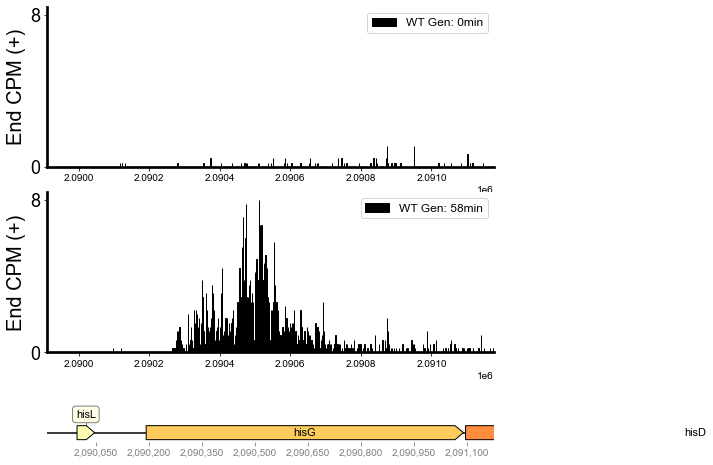

In [188]:
my_project.plot_end_CPM(by = 'operon',operon_name='hisL:hisG',extension=85,mode='separated',
                        sample_list=['Gen_T0','Gen_T5'],ylim=[0,8],colors=['black','black'])


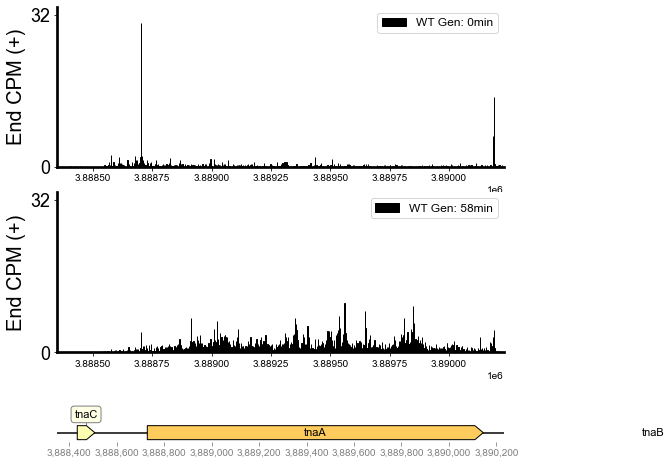

In [189]:
fig = my_project.plot_end_CPM(by = 'operon',operon_name='tnaC:tnaA',extension=85,mode='separated',
                        sample_list=['Gen_T0','Gen_T5'],ylim=[0,32],colors=['black','black'])
plt.savefig('./Final_plots/tnaC_tnaA.svg')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


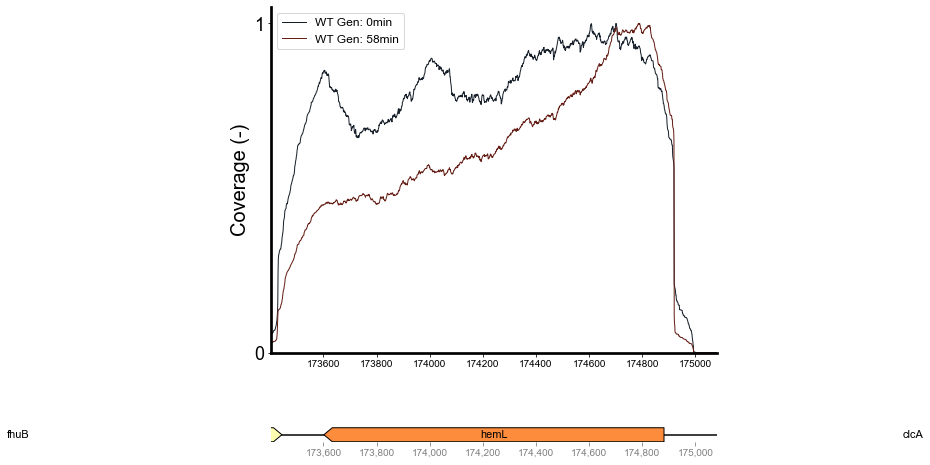

In [219]:
fig = my_project.plot_coverage(by = 'gene',feature_name='hemL',extension=200,ylim = [0,1],
                               max_norm=True,sample_list=['Gen_T0','Gen_T5'])
